# Exercise: putting everything together \[Solution\]


In this you will write code for a model that learns to classify mnist digits. You will use sonnet and tensorflow, tracking training progress with matplotlib.

In [1]:
# Install dm-sonnet with pip. Include all necessary imports.

!pip install dm-sonnet

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import random
import seaborn as sns
import numpy as np
import tensorflow as tf
import sonnet as snt

from matplotlib import pyplot as plt
from google.colab import files
from scipy.stats import multivariate_normal
from IPython.display import clear_output, Image, display, HTML

sns.set_style('ticks')


In [2]:
tf.reset_default_graph()

In [3]:
# Fetch the mnist data from tf.keras.datasets.mnist.

mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

# Check what the data is like:
print('Training dataset:')
train_input, train_label = mnist_train
print('* input shape:', train_input.shape)
print('* input min, mean, max:', train_input.min(), train_input.mean(), train_input.max())
print('* input dtype:', train_input.dtype)
print('* label shape:', train_label.shape)
print('* label min, mean, max:', train_label.min(), train_label.mean(), train_label.max())
print('* label dtype:', train_label.dtype)

test_input, test_label = mnist_test
print('Number of test examples:', test_input.shape[0])

Training dataset:
* input shape: (60000, 28, 28)
* input min, mean, max: 0 33.318421449829934 255
* input dtype: uint8
* label shape: (60000,)
* label min, mean, max: 0 4.4539333333333335 9
* label dtype: uint8
Number of test examples: 10000


Normalize the data into the \[0, 1\] interval. It's also a good idea to check the class distribution, but here we know that this is OK.



In [4]:
# Normalize both train_input and test_input so that it is in [0, 1].
#
# Also ensure the following data types:
#
# * train_input and test_input need to be np.float32.
# * the labels need to be converted to np.int32.

train_input = train_input.astype(np.float32) / 255.
test_input = test_input.astype(np.float32) / 255.

train_label = train_label.astype(np.int32)
test_label = test_label.astype(np.int32)


In [5]:
# We can visualize the first few training examples using matplotlib.imshow()
# in combination with the gallery function we defined.
#
# Copy the gallery function in this cell.

def gallery(array, ncols=10, rescale=True):
  """Take a batch of images and arrange them in a grid.
  
  Args:
    array: of shape batch_size x height x width x 3. The final x3 in the shape
      is optional.
    ncols: number of columns to have in the grid
    rescale: if true (default), increases the intensity of the images.
    
  Returns:
    A numpy array which contains the batch of images arranged into
    a grid.
  """
  if rescale:
    array = (array + 1.) / 2
  nindex, height, width = array.shape[:3]

  nrows = nindex//ncols
  assert nindex == nrows*ncols

  # want result.shape = (height*nrows, width*ncols, intensity?)
  abstract_grid_shape = [nrows, ncols, height, width]
  image_grid_shape = [height*nrows, width*ncols]
  if len(array.shape) == 4:
    intensity = array.shape[3]
    abstract_grid_shape.append(intensity)
    image_grid_shape.append(intensity)
 
  result = (array.reshape(*abstract_grid_shape)
            .swapaxes(1,2)
            .reshape(*image_grid_shape))
  return result


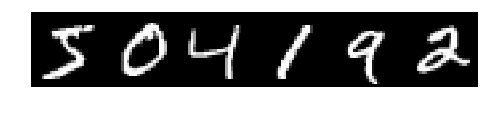

[5 0 4 1 9 2]


In [6]:
# Show the first 6 training images on a 1x6 grid.
# Remember to use grayscale plotting.
# Also print their corresponding labels in the same order.

plt.figure()
plt.gray()
plt.axis('off')
plt.imshow(gallery(train_input[:6], ncols=6, rescale=False))
plt.show()

print(train_label[:6])

In [7]:
# Write a function that turns the data into tensorflow datasets and into
# tensors corresponding to batches of examples, returning these tensors.
#
# The train data should be
#
# * shuffled across the full dataset
# * repeated indefinitely
# * batched at size 64.
#
# Simply batch the test data.
#
# IMPORTANT: Add a final (singleton) axis to the inputs; the conv nets that
# we will use will expect this.

BATCH_SIZE = 64


def _get_data_tensor(dataset):
  return dataset.make_one_shot_iterator().get_next()


def get_tf_data():
  train_dataset = tf.data.Dataset.from_tensor_slices((
      np.expand_dims(train_input, axis=-1), train_label))
  train_dataset = train_dataset.shuffle(60000).repeat().batch(BATCH_SIZE)
  train_data = _get_data_tensor(train_dataset)

  test_dataset = tf.data.Dataset.from_tensor_slices((
      np.expand_dims(test_input, axis=-1), test_label))
  test_dataset = test_dataset.batch(BATCH_SIZE)
  test_data = _get_data_tensor(test_dataset)
  
  return train_data, test_data


# Check the function outputs.
get_tf_data()

((<tf.Tensor 'IteratorGetNext:0' shape=(?, 28, 28, 1) dtype=float32>,
  <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=int32>),
 (<tf.Tensor 'IteratorGetNext_1:0' shape=(?, 28, 28, 1) dtype=float32>,
  <tf.Tensor 'IteratorGetNext_1:1' shape=(?,) dtype=int32>))

In [8]:
# Make a sonnet module that has the following structure:
#
# 1. sonnet Conv2D with 16 channes, kernel shape 3, stride 1, padding 'SAME'
# 2. max pooling with window_shape [3, 3], srides [2, 2], padding 'SAME'
# 3. ReLU
# 4. sonnet Conv2D with 16 channes, kernel shape 3, stride 1, padding 'SAME'
# 5. Flatten the final conv features using snt.BatchFlatten
# 5. A (dense) Linear layer with output_size = 10, the number of classes.
#
# You can write the sonnet module yourself, or use the helper module
# snt.Sequential([..layers..to..connect..]).

def make_network():
  
  def make_conv_layer():
    return snt.Conv2D(16, 3, stride=1, padding='SAME')
  
  def pooling_layer(inputs):
    return tf.nn.pool(
        inputs,
        window_shape=[3, 3],
        pooling_type='MAX',
        padding='SAME',
        strides=[2, 2])

  return snt.Sequential([
      make_conv_layer(),
      pooling_layer,
      tf.nn.relu,
      make_conv_layer(),
      snt.BatchFlatten(),
      snt.Linear(10),
  ])


# Check the function outputs.
make_network()

In [9]:
tf.reset_default_graph()
(train_inputs, train_labels), (test_inputs, test_labels) = get_tf_data()


In [10]:
# 1. Instantiate a model
# 2. Hook it up to the training data,
# 3. Use the `tf.nn.sparse_softmax_cross_entropy_with_logits` op to define the loss
# 4. Define the train_op that minimizes the loss (averaged over the batch)
#    using the `GradientDescentOptimizer`. Set the learning rate to 0.01.
# 5. Get the initialization op.

model = make_network()

train_outputs = model(train_inputs)
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=train_labels,
    logits=train_outputs,
)
loss = tf.reduce_mean(loss)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(loss)

init_op = tf.global_variables_initializer()


In [11]:
# Write a function that takes a list of losses and plots them.
def plot_losses(loss_list):
  plt.figure()
  plt.title('Losses')
  plt.plot(loss_list, c='b')
  plt.show()

train iter 0


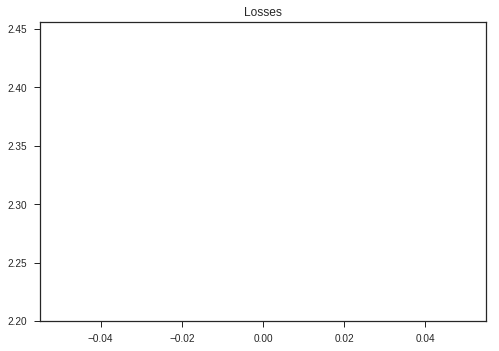

Accuracy on training set: 0.175
train iter 500


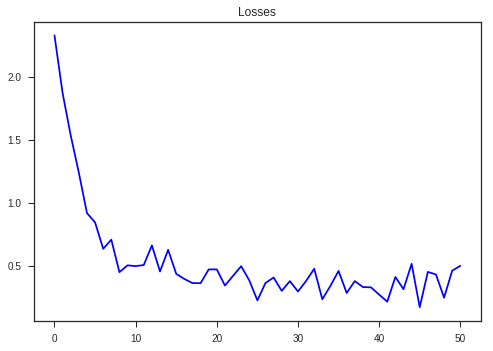

Accuracy on training set: 0.890104166667
Test Pred accuracy: 0.913


In [12]:
# Run the training loop, keeping track of losses and potentially the accuracy
# on the training set. Plot the loss curve intermittently.
#
# The simplest solution would add a new plot with each plotting call. You
# can play with the frequency of plotting (and recording) a bit in order
# to find something that works.
#
# Based on the loss curves, decide how to set your total number of training
# iterations. Once you are satified, add some code that evaluates your
# prediction accuracy (not loss!) on the test set.
#
# Note that the outputs from the network are logits; for prediction accuracy
# we can pick the most likely label and see if it is correct.
#
# You should be able to reach about 90% correctness in roughly 1000 training
# steps.


TRAIN_ITERS = int(1000)
RECORD_PERIOD = 10
PLOT_PERIOD = int(500)


def get_accuracy(predictions, true_labels):
  assert predictions.shape == true_labels.shape  
  num_elements = predictions.shape[0]
  num_correct = np.count_nonzero(np.isclose(predictions, true_labels))
  return num_correct / num_elements
  

def get_predictions_and_true_labels(
    session, outputs_tensor, labels_tensor, num_batches=-1):
  all_predictions = []
  all_true_labels = []
  while num_batches != 0:
    try:
      outputs_np, labels_np = session.run([outputs_tensor, labels_tensor])
      if num_batches > 0:
        num_batches -= 1

      assert len(outputs_np.shape) == 2
      predictions = outputs_np.argmax(axis=1)
      all_predictions.append(predictions)
      all_true_labels.append(labels_np)
    except tf.errors.OutOfRangeError:
      break
      
  # Concatenate all collected data.
  return (
      np.concatenate(all_predictions),
      np.concatenate(all_true_labels),      
  )


losses = []
with tf.Session() as session:
  session.run(init_op)
  
  for train_iter in range(TRAIN_ITERS):
    _, loss_np = session.run([train_op, loss])
    
    if (train_iter % RECORD_PERIOD) == 0:
      losses.append(loss_np)
  
    if (train_iter % PLOT_PERIOD) == 0:
      print('train iter', train_iter)
      plot_losses(losses)
      predictions, true_labels = get_predictions_and_true_labels(
          session, train_outputs, train_labels, num_batches=30)
      print('Accuracy on training set:', get_accuracy(predictions, true_labels))
     
  print('Test Pred accuracy:', get_accuracy(
      *get_predictions_and_true_labels(
          session, model(test_inputs), test_labels, num_batches=-1)
  ))
